In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def collectingLatestBTC(timePeriod="5y"):
    r = requests.get("https://api.coinranking.com/v2/coin/Qwsogvtv82FCd/history?timePeriod=" + timePeriod)
    latest_coin = json.loads(r.text)["data"]["history"]  
    df = pd.DataFrame(latest_coin) 
    df['price'] = pd.to_numeric(df['price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s').dt.date
    return df.groupby('timestamp').mean()['price']

In [3]:
def preparing_prices(data, seq_len=30):
    
    price_matrix = []
    for index in range(len(data)-seq_len+1):
        price_matrix.append(data[index:index+seq_len])
    return price_matrix
def normalize_prices(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [4]:
def TrainTestSplit(price_matrix, train_size=0.9, shuffle=False, return_row=True):
    price_matrix = np.array(price_matrix)
    row = int(round(train_size * len(price_matrix)))
    train = price_matrix[:row, :]
    if shuffle==True:
        np.random.shuffle(train)
    X_train, y_train = train[:row,:-1], train[:row,-1]
    X_test, y_test = price_matrix[row:,:-1], price_matrix[row:,-1]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    if return_row:
        return row, X_train, y_train, X_test, y_test
    else:
        X_train, y_train, X_test, y_test
 

In [5]:
import tensorflow

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM, Dense, Activation

import time

data = collectingLatestBTC() 

prices = preparing_prices (data) 

prices = normalize_prices (prices) 

row, X_train, y_train, X_test, y_test = TrainTestSplit(prices)

model=Sequential()

model.add(LSTM(50,return_sequences=True,input_shape=(29,1)))

model.add(LSTM(50,return_sequences=True))

model.add(LSTM(50))

model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

start_time = time.time()

history= model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=64,verbose=1,validation_split=0.01)

end_time = time.time()

processing_time = end_time - start_time

model.save("model/coinpredict.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 29, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 29, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
25/25 [==============================] - 6s 78ms/step - loss: 0.0376 - val_loss: 0.0084
Epoch 2/20
25/25 [==============================] - 1s 41ms/step - loss: 0.0145 - val

In [6]:
data.head()

timestamp
2017-01-03    1033.30
2017-01-04    1135.41
2017-01-05     989.35
2017-01-06     886.16
2017-01-07     888.87
Name: price, dtype: float64

In [7]:
data.tail()

timestamp
2021-12-30    46563.534742
2021-12-31    47217.186572
2022-01-01    46331.005291
2022-01-02    47778.493993
2022-01-03    47306.546984
Name: price, dtype: float64

In [8]:
from tensorflow.keras.models import load_model
model = load_model('model/coinpredict.h5') 
preds = model.predict(X_test, batch_size=2)
preds_price= model.predict((preds-0.1), batch_size=2)

In [9]:
def denormalizer(preds, data, train_size=0.9, train_phase=False):
    price_matrix = np.array(preparing_prices(data))
    if train_phase:
        row = int(round(train_size * len(price_matrix)))
    else:
        row = 0
    date = data.index[row + 29:]
    date = np.reshape(date, (date.shape[0]))
    X_test = price_matrix[row:, :-1]
    y_test = price_matrix[row:, -1]
    preds_original = []
    preds = np.reshape(preds, (preds.shape[0]))
    for index in range(0, len(preds)):
        pred = (preds[index] + 1) * X_test[index][0]
        preds_original.append(pred)
    preds_original = np.array(preds_original)
    if train_phase:
        return [date, y_test, preds_original]
    else:
        import datetime
        return [date + datetime.timedelta(days=1), y_test]

In [10]:
final_pred = denormalizer(preds, data, train_size=0.5, train_phase=False)
final_pred[1][0]

982.4299998534411

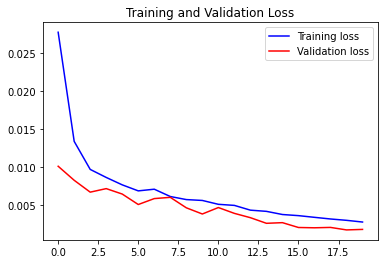

In [11]:
loss = history.history['loss']
val_loss =history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label ='Training loss')
plt.plot(epochs, val_loss,'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

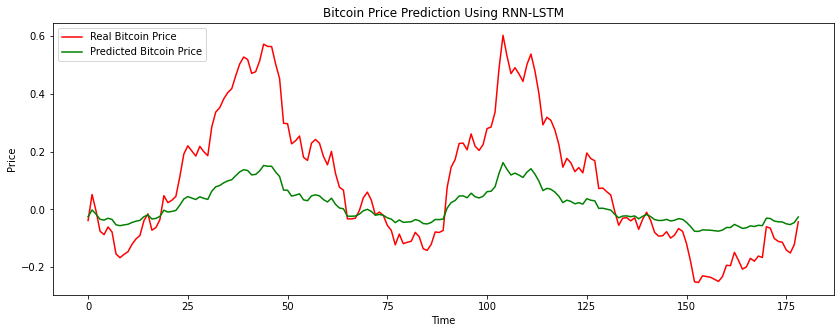

In [9]:
plt.figure(figsize=(14,5))
plt.plot(preds, color ='red', label = 'Real Bitcoin Price')
plt.plot(preds_price, color ='green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction Using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [10]:
import requests,json,numpy as np,pandas as pd
def collectingLatestBTC(timePeriod="5y"):
    r = requests.get("https://api.coinranking.com/v2/coin/Qwsogvtv82FCd/history?timePeriod=" + timePeriod)
    latest_coin = json.loads(r.text)["data"]["history"]  
    df = pd.DataFrame(latest_coin)
    df['price'] = pd.to_numeric(df['price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s').dt.date
    return df.groupby('timestamp').mean()['price']
def preparing_prices(data, seq_len=30):
    
    price_matrix = []
    for index in range(len(data)-seq_len+1):
        price_matrix.append(data[index:index+seq_len])
    return price_matrix
def normalize_prices(window_data):
    
    normalised_data = []
    for window in window_data:
        
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data
def denormalizer(preds, data, train_size=0.9, train_phase=False):
    price_matrix = np.array(preparing_prices(data))
    if train_phase:
        row = int(round(train_size * len(price_matrix)))
    else:
        row = 0
    date = data.index[row + 29:]
    date = np.reshape(date, (date.shape[0]))
    X_test = price_matrix[row:, :-1]
    y_test = price_matrix[row:, -1]
    preds_original = []
    preds = np.reshape(preds, (preds.shape[0]))
    for index in range(0, len(preds)):
        pred = (preds[index] + 1) * X_test[index][0]
        preds_original.append(pred)
    preds_original = np.array(preds_original)
    if train_phase:
        return [date, y_test, preds_original]
    else:
        import datetime
        return [date + datetime.timedelta(days=1), y_test]

In [ ]:
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtWidgets import QApplication
from keras.models import load_model

class Ui_MainWindow(object):
    data2 = collectingLatestBTC(timePeriod='30d')[1:31]
    todaysvalue = str(data2[-1:][0])
    result = "0.0"
    def setupUi(self, MainWindow):
        MainWindow.setObjectName("MainWindow")
        MainWindow.resize(480, 320)
        font = QtGui.QFont()
        font.setFamily("Times New Roman")
        font.setPointSize(9)
        font.setBold(True)
        font.setItalic(True)
        font.setWeight(75)
        MainWindow.setFont(font)
        MainWindow.setStyleSheet("")
        self.centralwidget = QtWidgets.QWidget(MainWindow)
        self.centralwidget.setObjectName("centralwidget")
        self.title_label_frame = QtWidgets.QFrame(self.centralwidget)
        self.title_label_frame.setGeometry(QtCore.QRect(0, 30, 480, 40))
        self.title_label_frame.setCursor(QtGui.QCursor(QtCore.Qt.ArrowCursor))
        self.title_label_frame.setAutoFillBackground(True)
        self.title_label_frame.setFrameShape(QtWidgets.QFrame.Box)
        self.title_label_frame.setFrameShadow(QtWidgets.QFrame.Raised)
        self.title_label_frame.setObjectName("title_label_frame")
        self.horizontalLayout = QtWidgets.QHBoxLayout(self.title_label_frame)
        self.horizontalLayout.setObjectName("horizontalLayout")
        self.label_5 = QtWidgets.QLabel(self.title_label_frame)
        font = QtGui.QFont()
        font.setPointSize(10)
        font.setBold(True)
        font.setWeight(75)
        self.label_5.setFont(font)
        self.label_5.setStyleSheet("background-color: rgb(153,153,255);")
        self.label_5.setTextFormat(QtCore.Qt.PlainText)
        self.label_5.setScaledContents(True)
        self.label_5.setIndent(-1)
        self.label_5.setObjectName("label_5")
        self.horizontalLayout.addWidget(self.label_5)
        self.current_label_frame = QtWidgets.QFrame(self.centralwidget)
        self.current_label_frame.setGeometry(QtCore.QRect(10, 80, 261, 51))
        self.current_label_frame.setCursor(QtGui.QCursor(QtCore.Qt.ArrowCursor))
        self.current_label_frame.setAutoFillBackground(False)
        self.current_label_frame.setStyleSheet("background-color: rgb(198,206,255);")
        self.current_label_frame.setFrameShape(QtWidgets.QFrame.Box)
        self.current_label_frame.setFrameShadow(QtWidgets.QFrame.Raised)
        self.current_label_frame.setObjectName("current_label_frame")
        self.horizontalLayout_2 = QtWidgets.QHBoxLayout(self.current_label_frame)
        self.horizontalLayout_2.setObjectName("horizontalLayout_2")
        self.label = QtWidgets.QLabel(self.current_label_frame)
        font = QtGui.QFont()
        font.setFamily("MS Shell Dlg 2")
        font.setPointSize(9)
        font.setBold(True)
        font.setItalic(False)
        font.setWeight(75)
        self.label.setFont(font)
        self.label.setStyleSheet("color: rgb(167, 55, 0);\n"
                                 "alternate-background-color: rgb(255, 255, 0);")
        self.label.setTextFormat(QtCore.Qt.PlainText)
        self.label.setIndent(-1)
        self.label.setObjectName("label")
        self.horizontalLayout_2.addWidget(self.label)
        self.tomorrow_label_frame = QtWidgets.QFrame(self.centralwidget)
        self.tomorrow_label_frame.setGeometry(QtCore.QRect(10, 140, 261, 51))
        self.tomorrow_label_frame.setCursor(QtGui.QCursor(QtCore.Qt.ArrowCursor))
        self.tomorrow_label_frame.setAutoFillBackground(False)
        self.tomorrow_label_frame.setStyleSheet("background-color: rgb(198, 206, 255);")
        self.tomorrow_label_frame.setFrameShape(QtWidgets.QFrame.Box)
        self.tomorrow_label_frame.setFrameShadow(QtWidgets.QFrame.Raised)
        self.tomorrow_label_frame.setObjectName("tomorrow_label_frame")
        self.horizontalLayout_3 = QtWidgets.QHBoxLayout(self.tomorrow_label_frame)
        self.horizontalLayout_3.setObjectName("horizontalLayout_3")
        self.label_2 = QtWidgets.QLabel(self.tomorrow_label_frame)
        font = QtGui.QFont()
        font.setPointSize(9)
        font.setBold(True)
        font.setWeight(75)
        self.label_2.setFont(font)
        self.label_2.setStyleSheet("color: rgb(167, 55, 0);\n"
                                   "alternate-background-color: rgb(255, 255, 0);")
        self.label_2.setTextFormat(QtCore.Qt.PlainText)
        self.label_2.setIndent(-1)
        self.label_2.setObjectName("label_2")
        self.horizontalLayout_3.addWidget(self.label_2)
        self.current_value_frame = QtWidgets.QFrame(self.centralwidget)
        self.current_value_frame.setGeometry(QtCore.QRect(280, 80, 191, 51))
        self.current_value_frame.setCursor(QtGui.QCursor(QtCore.Qt.ArrowCursor))
        self.current_value_frame.setAutoFillBackground(True)
        self.current_value_frame.setFrameShape(QtWidgets.QFrame.Box)
        self.current_value_frame.setFrameShadow(QtWidgets.QFrame.Raised)
        self.current_value_frame.setObjectName("current_value_frame")
        self.horizontalLayout_4 = QtWidgets.QHBoxLayout(self.current_value_frame)
        self.horizontalLayout_4.setObjectName("horizontalLayout_4")
        self.label_3 = QtWidgets.QLabel(self.current_value_frame)
        font = QtGui.QFont()
        font.setPointSize(10)
        self.label_3.setFont(font)
        self.label_3.setTextFormat(QtCore.Qt.PlainText)
        self.label_3.setIndent(-1)
        self.label_3.setObjectName("label_3")
        self.horizontalLayout_4.addWidget(self.label_3)
        self.tomorrow_value_frame = QtWidgets.QFrame(self.centralwidget)
        self.tomorrow_value_frame.setGeometry(QtCore.QRect(280, 140, 191, 51))
        self.tomorrow_value_frame.setCursor(QtGui.QCursor(QtCore.Qt.ArrowCursor))
        self.tomorrow_value_frame.setAutoFillBackground(False)
        self.tomorrow_value_frame.setStyleSheet("background-color: rgb(255, 255, 255);")
        self.tomorrow_value_frame.setFrameShape(QtWidgets.QFrame.Box)
        self.tomorrow_value_frame.setFrameShadow(QtWidgets.QFrame.Raised)
        self.tomorrow_value_frame.setObjectName("tomorrow_value_frame")
        self.horizontalLayout_5 = QtWidgets.QHBoxLayout(self.tomorrow_value_frame)
        self.horizontalLayout_5.setObjectName("horizontalLayout_5")
        self.label_4 = QtWidgets.QLabel(self.tomorrow_value_frame)
        font = QtGui.QFont()
        font.setPointSize(10)
        self.label_4.setFont(font)
        self.label_4.setTextFormat(QtCore.Qt.PlainText)
        self.label_4.setIndent(-1)
        self.label_4.setObjectName("label_4")
        self.horizontalLayout_5.addWidget(self.label_4)
        self.frame = QtWidgets.QFrame(self.centralwidget)
        self.frame.setGeometry(QtCore.QRect(0, 0, 480, 291))
        self.frame.setStyleSheet("background-color: #053742;")
        self.frame.setFrameShape(QtWidgets.QFrame.StyledPanel)
        self.frame.setFrameShadow(QtWidgets.QFrame.Raised)
        self.frame.setObjectName("frame")
        
        self.pushButton = QtWidgets.QPushButton(self.frame)
        self.pushButton.setGeometry(QtCore.QRect(370, 230, 93, 28))
        self.pushButton.setStyleSheet("color: rgb(255, 255, 255);\n"
                                      "background-color: rgb(255, 0, 0);")
        self.pushButton.setObjectName("pushButton")
        self.pushButton.clicked.connect(self.cancel_button)
        
        self.pushButton_2 = QtWidgets.QPushButton(self.frame)
        self.pushButton_2.setGeometry(QtCore.QRect(270, 230, 93, 28))
        self.pushButton_2.setStyleSheet("background-color: rgb(85, 170, 0);\n"
                                        "color: rgb(255, 255, 255);")
        self.pushButton_2.setObjectName("pushButton_2")
        self.pushButton_2.clicked.connect(self.predict_button)
        self.frame.raise_()
        self.title_label_frame.raise_()
        
        self.tomorrow_value_frame.raise_()
        self.tomorrow_label_frame.raise_()
        
        MainWindow.setCentralWidget(self.centralwidget)
        self.statusbar = QtWidgets.QStatusBar(MainWindow)
        self.statusbar.setObjectName("statusbar")
        MainWindow.setStatusBar(self.statusbar)
        self.retranslateUi(MainWindow)
        QtCore.QMetaObject.connectSlotsByName(MainWindow)
    def cancel_button(self):
        sys.exit(app.exec_())
    def predict_button(self):
        self.result = self.prediction_result()
        self.result = str(self.result)
        print(self.result)
        self.label_4.setText(self.result)
    def prediction_result(self):
        price_matrix = preparing_prices(self.data2)
        X_test = normalize_prices(price_matrix)
        X_test = np.array(X_test)
        if X_test.shape[1] >= 30:
            X_test = X_test[0][-29:]
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (1, X_test.shape[0], 1))
        
        model = load_model('model/coinpredict.h5')
        preds = model.predict(X_test, batch_size=2)
        final_pred = denormalizer(preds, self.data2, train_size=0.7, train_phase=False)
        next_day_value = final_pred[1][0]
        return next_day_value
    def retranslateUi(self, MainWindow):
        _translate = QtCore.QCoreApplication.translate
        MainWindow.setWindowTitle(_translate("MainWindow", "Bitcoin Predictor"))
        self.label_5.setText(_translate("MainWindow", "BTC VALUE OF TOMORROW"))
        
        self.label_2.setText(_translate("MainWindow", "THE PREDICTED BTC VALUE"))
        self.label_3.setText(_translate("MainWindow", self.todaysvalue))
        self.label_4.setText(_translate("MainWindow", self.result))
        self.pushButton.setText(_translate("MainWindow", "QUIT"))
        self.pushButton_2.setText(_translate("MainWindow", "PREDICT"))
if __name__ == '__main__':
    import sys
    app = QApplication(sys.argv)
    window = QtWidgets.QMainWindow()
    ui = Ui_MainWindow()
    ui.setupUi(window)
    window.show()
    sys.exit(app.exec_())

47196.397155415914
47196.397155415914
47196.397155415914
